# Harley Wood School for Astronomy 2019 

<img src="https://research.smp.uq.edu.au/asa2019/static/asa19/img/HWSA2019-logo.png" width=300>

## Part I - Good Code Etiquette or how to make your code more effective and efficient

In this part of the workshop we will look at an example code to reproduce HR diagrams using Gaia data.

<img src="https://www.cosmos.esa.int/documents/29201/1666086/kine_all.png/8b9de0b4-8eb1-ad73-0922-9bf323687f6e?t=1524224828914" width=400>

The above Gaia Hertzsprung-Russell diagrams, Gaia absolute magnitude versus GBP-GRP colour, are a function of the stars tangential velocity (VT), using Gaia DR2 with relative parallax uncertainty better than 10% and low extinction stars (E(B-V)<0.015), together with astrometric and photometric quality filters. The colour scale represents the square root of the density


## Table of Contents

1. [Downloading the data](#Downloading-the-data)
2. [Cleaning the data](#Cleaning-the-data)
3. [Plotting the HR diagram](#Plotting-the-HR-diagram)


### Required libraries

This notebook uses several Python packages that come standard with the [Anaconda Python distribution](http://continuum.io/downloads). The primary libraries that we'll be using are:

* **astropy**
* **astroquery**
* **numpy**
* **pandas**
* **matplotlib**
* **seaborn**

To make sure you have all of the packages you need, install them with `conda`:

    conda install [package name]
    conda install -c astropy astroquery
    
`conda` may ask you to update some of the packages if you don't have the most recent version. Allow it to do so.

Alternatively, if you can install the packages with [pip](https://pip.pypa.io/en/stable/installing/) (a Python package manager):

    pip install [package name]
    
Be sure to restart your kernel if you had to install new packages.

# Downloading the data

We can download data from Gaia using the astroquery library, specifically we are using the Table Access Protocol (TAP) specified by the International Virtual Observatory Alliance.

[TAP astroquery docs](https://astroquery.readthedocs.io/en/latest/utils/tap.html)

[Gaia Tap examples](https://gaia.aip.de/cms/documentation/tap-interface/)

## Proposed improvements:

- include an author statement
- have the import statements at the beginning
- create functions for often repeated code
- replace the for loop with an np.where mask
- replace the log10 function with np.log
- vectorise!!!!!!
- change variable names to be more transparent
- plotted the uncleaned data set -> updated to cleaned data set
- make lines shorter by inlcuding line breaks
- try expect statement to get around problems with latex rendering in the plotting
- the order of code should be cleaned up - clean data before calculating new values to decrease amount of compute
- 0th order improvement: as we are reading from a database let the databse do a lot of the heavy lifting for you!
- putting things into functions and returning only the required output will help with clenaing up memory and less likely to introduce bugs due to using same variable names

In [ ]:
#List available tables
from astroquery.utils.tap.core import TapPlus

gaia = TapPlus(url="https://gaia.aip.de/tap")
tables = gaia.load_tables()
for table in (tables):
    print(table.get_qualified_name())

In [ ]:
# Load DR2 source table and check columns
from astroquery.utils.tap.core import TapPlus

gaia = TapPlus(url="http://gea.esac.esa.int/tap-server/tap")
table = gaia.load_table('gaiadr2.gaia_source')
for column in (table.columns):
    print(column.name)

**WARNING** This query takes a long time. Please load the data from the file given to you by the instructors

In [ ]:
# # Download gaia dr 2 source table, save to disk
# gaia = TapPlus(url="http://gea.esac.esa.int/tap-server/tap")
# job = gaia.launch_job_async("select * from gaiadr2.gaia_source order by source_id", dump_to_file=True)
# print(job)

In [ ]:
# # return result of query 
# t = job.get_results()

# Cleaning the data

The aim of this section is to make sure we have useful data, ie:
- remove NaN
- calculate the absolute magnitude
- subset into different location or velocity bins, we are interestedn in:

|Name        |Type        |UCD         |Unit        |Description |
|------------|------------|------------|------------|------------|
|bp_rp 	|float 	|phot.color 	|Magnitude[mag] 	|BP - RP colour|
|bp_g 	|float 	|phot.color 	|Magnitude[mag] 	|BP - G colour|
|g_rp 	|float 	|phot.color 	|Magnitude[mag] 	|G - RP colour|
|radial_velocity 	|double 	|spect.dopplerVeloc.opt 	|Velocity[km/s] 	|Radial velocity |

In [1]:
#read data 
import pandas as pd
from astropy.io.votable import parse_single_table

table = parse_single_table("async_subset.vot")

t =table.to_table(use_names_over_ids=True)


In [2]:
#convert to pandas DF
import pandas as pd

df = t.to_pandas()

#check the data frame
df.head()

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url
0,1.635721e+18,b'Gaia DR2 4295806720',4.295807e+09,8.337194e+08,2015.5,44.996154,0.119382,0.005616,0.122872,0.071448,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b'http://geadata.esac.esa.int/data-server/data...,b''
1,1.635721e+18,b'Gaia DR2 34361129088',3.436113e+10,1.253687e+09,2015.5,45.004316,0.132215,0.021045,0.150330,3.486774,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b'http://geadata.esac.esa.int/data-server/data...,b''
2,1.635721e+18,b'Gaia DR2 38655544960',3.865554e+10,1.168974e+09,2015.5,45.004974,0.029723,0.019877,0.039862,3.121257,...,0.0728,200111.0,0.586399,0.565991,0.634422,0.187806,0.181569,0.194043,b'http://geadata.esac.esa.int/data-server/data...,b''
3,1.635721e+18,b'Gaia DR2 309238066432',3.092381e+11,7.163645e+08,2015.5,44.995037,0.374845,0.038152,0.354581,1.578841,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b'http://geadata.esac.esa.int/data-server/data...,b''
4,1.635721e+18,b'Gaia DR2 343597448960',3.435974e+11,1.007197e+09,2015.5,44.963895,0.167259,0.043595,0.158431,0.112423,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b'http://geadata.esac.esa.int/data-server/data...,b''


In [3]:
#convert to pandas df and calculate absolute mag
import pandas as pd
import numpy as np
from math import * # <- this is bad!

df['mg'] = 0
df['dist'] = 0

for c, v in enumerate(df['phot_g_mean_mag']):
    
    p =df.loc[c,'parallax']
    if p>0:
        df.loc[c,'mg'] = v + 5 * log10(p) - 10
        df.loc[c,'dist'] = 1000/p
    else:
        df.loc[c,'mg'] = np.nan
        df.loc[c,'dist'] = np.nan

df.head()

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,mg,dist
0,1.635721e+18,b'Gaia DR2 4295806720',4.295807e+09,8.337194e+08,2015.5,44.996154,0.119382,0.005616,0.122872,0.071448,...,NaN,NaN,NaN,NaN,NaN,NaN,b'http://geadata.esac.esa.int/data-server/data...,b'',1.923885,13996.227513
1,1.635721e+18,b'Gaia DR2 34361129088',3.436113e+10,1.253687e+09,2015.5,45.004316,0.132215,0.021045,0.150330,3.486774,...,NaN,NaN,NaN,NaN,NaN,NaN,b'http://geadata.esac.esa.int/data-server/data...,b'',10.316146,286.798048
2,1.635721e+18,b'Gaia DR2 38655544960',3.865554e+10,1.168974e+09,2015.5,45.004974,0.029723,0.019877,0.039862,3.121257,...,0.586399,0.565991,0.634422,0.187806,0.181569,0.194043,b'http://geadata.esac.esa.int/data-server/data...,b'',6.612138,320.383786
3,1.635721e+18,b'Gaia DR2 309238066432',3.092381e+11,7.163645e+08,2015.5,44.995037,0.374845,0.038152,0.354581,1.578841,...,NaN,NaN,NaN,NaN,NaN,NaN,b'http://geadata.esac.esa.int/data-server/data...,b'',10.628842,633.375975
4,1.635721e+18,b'Gaia DR2 343597448960',3.435974e+11,1.007197e+09,2015.5,44.963895,0.167259,0.043595,0.158431,0.112423,...,NaN,NaN,NaN,NaN,NaN,NaN,b'http://geadata.esac.esa.int/data-server/data...,b'',3.402767,8894.958511


In [25]:
df.describe()[['bp_rp','bp_g','g_rp','mg','dist','radial_velocity']]

,bp_rp,bp_g,g_rp,mg,dist,radial_velocity
count,9508.000000,9508.000000,9516.000000,7167.000000,7.167000e+03,201.000000
mean,1.592572,0.652144,0.940678,7.761444,3.813396e+03,8.060169
std,0.659445,0.479502,0.362201,2.866065,4.242946e+04,31.225478
min,-0.762651,-1.623127,-0.489988,-8.511513,4.153021e+01,-100.827790
25%,1.036546,0.368594,0.637967,5.687873,5.632443e+02,-11.171938
50%,1.536821,0.591612,0.927489,7.936825,9.888230e+02,10.731324
75%,2.104440,0.979115,1.185433,9.989220,1.908346e+03,28.378986
max,3.947842,2.631605,2.320021,15.928603,1.971744e+06,118.393387


In [26]:
df_clean = df[(df.parallax_over_error > 10) & 
              (df.visibility_periods_used > 8) & 
              (df.phot_g_mean_flux_over_error > 50) & 
              (df.phot_bp_mean_flux_over_error > 20) & 
              (df.phot_rp_mean_flux_over_error > 20)]

In [27]:
df_clean.describe()[['bp_rp','bp_g','g_rp','mg','dist','radial_velocity']]

,bp_rp,bp_g,g_rp,mg,dist,radial_velocity
count,1439.000000,1439.000000,1439.000000,1439.000000,1439.000000,153.000000
mean,1.440554,0.682729,0.757825,6.327796,706.424858,6.301689
std,0.602866,0.363490,0.243321,2.311345,446.982923,32.559236
min,-0.180346,-0.095276,-0.085070,-1.559809,41.530213,-100.827790
25%,0.953651,0.397984,0.556020,4.687332,385.722304,-12.790695
50%,1.247699,0.555740,0.691648,6.144691,608.944904,6.287234
75%,1.875621,0.919374,0.959236,8.037373,942.327347,28.030645
max,3.373483,2.022471,1.550410,12.133822,3740.137517,118.393387


In [28]:
#remove nan
df_clean.dropna(subset=['bp_rp','bp_g','g_rp','mg','dist'], inplace=True)

dfsub = df_clean.loc[:,['bp_rp','bp_g','g_rp','mg','dist']]
dfsub.describe()

#remove nan radial velocity
# df_clean.dropna(subset=['bp_rp','bp_g','g_rp','mg','dist','radial_velocity'], inplace=True)

# dfsub = df_clean.loc[:,['bp_rp','bp_g','g_rp','mg','dist','radial_velocity']]
# dfsub.describe()

/Users/268964i/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,bp_rp,bp_g,g_rp,mg,dist
count,1439.000000,1439.000000,1439.000000,1439.000000,1439.000000
mean,1.440554,0.682729,0.757825,6.327796,706.424858
std,0.602866,0.363490,0.243321,2.311345,446.982923
min,-0.180346,-0.095276,-0.085070,-1.559809,41.530213
25%,0.953651,0.397984,0.556020,4.687332,385.722304
50%,1.247699,0.555740,0.691648,6.144691,608.944904
75%,1.875621,0.919374,0.959236,8.037373,942.327347
max,3.373483,2.022471,1.550410,12.133822,3740.137517


# Plotting the HR diagram

In this final section we will plot the HR diagram. 
For this we are creating a 2d histogram showing the number density, to be plotted on top of the scatterplot os the actual data.

|Name        |Type        |UCD         |Unit        |Description |
|------------|------------|------------|------------|------------|
|bp_rp 	|float 	|phot.color 	|Magnitude[mag] 	|BP - RP colour|
|bp_g 	|float 	|phot.color 	|Magnitude[mag] 	|BP - G colour|
|g_rp 	|float 	|phot.color 	|Magnitude[mag] 	|G - RP colour|
|radial_velocity 	|double 	|spect.dopplerVeloc.opt 	|Velocity[km/s] 	|Radial velocity |

**Create a well documented function to plot as only the input changes**

/Users/268964i/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:1211: RuntimeWarning: invalid value encountered in less
  res_mask = result.data < 0


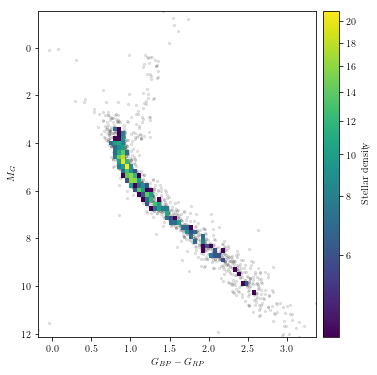

In [34]:
# plot the H-R diagram for BP - RP colour
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
plt.rc('text', usetex=True)



#select data for plotting
cstar = dfsub['bp_rp']
mg = dfsub['mg']

fig, ax = plt.subplots(figsize=(6, 6))
# only show 2D-histogram for bins with more than 5 stars in them
h = ax.hist2d(cstar, mg, bins=70, norm=colors.PowerNorm(0.5),cmin=5, zorder=0.5)
# fill the rest with scatter (set rasterized=True if saving as vector graphics)
ax.scatter(cstar, mg, alpha=0.1, s=5, color='k', zorder=0)
ax.invert_yaxis()
cb = fig.colorbar(h[3], ax=ax, pad=0.02)
ax.set_xlabel(r'$G_{BP} - G_{RP}$')
ax.set_ylabel(r'$M_G$')
cb.set_label(r"$\mathrm{Stellar~density}$")
plt.show()
# , norm=colors.PowerNorm(0.5), zorder=0.5

/Users/268964i/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:1211: RuntimeWarning: invalid value encountered in less
  res_mask = result.data < 0
/Users/268964i/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:1211: RuntimeWarning: invalid value encountered in less
  res_mask = result.data < 0


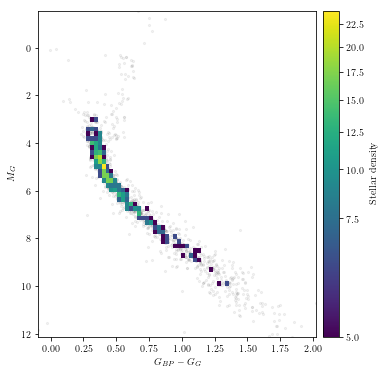

In [35]:
# plot the H-R diagram for BP - G colour
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
plt.rc('text', usetex=True)

#select data for plotting
cstar = dfsub['bp_g']
mg = dfsub['mg']

fig, ax = plt.subplots(figsize=(6, 6))
# only show 2D-histogram for bins with more than 5 stars in them
h = ax.hist2d(cstar, mg, bins=70, norm=colors.PowerNorm(0.5),cmin=5, zorder=0.5)
# fill the rest with scatter (set rasterized=True if saving as vector graphics)
ax.scatter(cstar, mg, alpha=0.05, s=5, color='k', zorder=0)
ax.invert_yaxis()
cb = fig.colorbar(h[3], ax=ax, pad=0.02)
ax.set_xlabel(r'$G_{BP} - G_{G}$')
ax.set_ylabel(r'$M_G$')
cb.set_label(r"$\mathrm{Stellar~density}$")
plt.show()
# , norm=colors.PowerNorm(0.5), zorder=0.5

/Users/268964i/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:1211: RuntimeWarning: invalid value encountered in less
  res_mask = result.data < 0


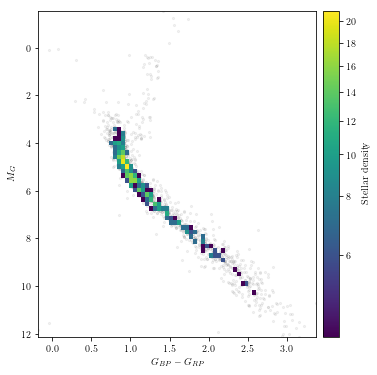

In [36]:
# plot the H-R diagram for BP - RP colour
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
plt.rc('text', usetex=True)

#select data for plotting
cstar = dfsub['bp_rp']
mg = dfsub['mg']

fig, ax = plt.subplots(figsize=(6, 6))
# only show 2D-histogram for bins with more than 5 stars in them
h = ax.hist2d(cstar, mg, bins=70, norm=colors.PowerNorm(0.5),cmin=5, zorder=0.5)
# fill the rest with scatter (set rasterized=True if saving as vector graphics)
ax.scatter(cstar, mg, alpha=0.05, s=5, color='k', zorder=0)
ax.invert_yaxis()
cb = fig.colorbar(h[3], ax=ax, pad=0.02)
ax.set_xlabel(r'$G_{BP} - G_{RP}$')
ax.set_ylabel(r'$M_G$')
cb.set_label(r"$\mathrm{Stellar~density}$")
plt.show()
# , norm=colors.PowerNorm(0.5), zorder=0.5

Within your groups work through the notebook and figure out what is being done, discuss how you would improve the code presented here.
Then work through and implement as many of the changes you thought of.
Some of the things to look out for:
- implicit vs explicit, how easy is it to follow what has been done? Are there enough comments? What about variable names, do they make sense?
- is the notebook logicaly structured?
- how much code is repeated?
- loops
- check out the information on how to query the gaia database

The catalogue we queried is here: https://gaia.aip.de/metadata/gdr2/gaia_source/
Tap examples: https://astroquery.readthedocs.io/en/latest/utils/tap.html